### Spatial mapping of human lung region snRNA-seq to Visium (for Elo) - with scVI non-amortised inference

In [1]:
import sys
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

Global seed set to 0


`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU.   
Do not forget to change `device=cuda4` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job.

### Outline

1. Loading Visium data and single cell reference
2. Show UMAP of cells and locations
3. cell2location analysis in one step
4. Automatic discrete region identification by clustering cell densities
5. Visualize cell type density gradients using diffusion maps
6. Identify co-occuring cell type combinations using matrix factorisation



## 1. Loading Visium data and single cell reference

First let's read spatial Visium data from 10X Space Ranger output. Here we load sample annotations.

In [2]:
sp_data_folder = '/nfs/team205/vk7/sanger_projects/large_data/lung_airway_km/regions_with_visium_all/'
sc_data_folder = '/nfs/team205/vk7/sanger_projects/large_data/lung_airway_km/'
results_folder = '/nfs/team205/vk7/sanger_projects/collaborations/adult_lung_mapping/results/'
scvi_ref_run_name = f'{results_folder}/non_amortised/v0_Adam_4000iter_snsc_selection_CCLplasma_v4Ref'
scvi_run_name = f'{results_folder}/non_amortised/v3_nonamortised_Adam_alpha50_40k_lr0002_CCLplasma_long_ref_wo_lowQ_v4Ref'

annotation_folder = '/nfs/team205/vk7/sanger_projects/collaborations/adult_lung_mapping/data/Loupe_annotations/'

#sample_name = pd.Series(['WSA_LngSP8759310', 'WSA_LngSP8759311', 'WSA_LngSP8759312', 'WSA_LngSP8759313',
#                         'WSA_LngSP9258463', 'WSA_LngSP9258467', 'WSA_LngSP9258462', 'WSA_LngSP9258466',
#                         'WSA_LngSP9258465', 'WSA_LngSP9258469', 'WSA_LngSP9258464', 'WSA_LngSP9258468',
#                         'WSA_LngSP10193345', 'WSA_LngSP10193346', 'WSA_LngSP10193347', 'WSA_LngSP10193348'
#                        ])

sample_name = pd.Series(['WSA_LngSP8759311', 'WSA_LngSP8759312', 'WSA_LngSP8759313', 'WSA_LngSP9258463', 
                         'WSA_LngSP9258467', 'WSA_LngSP9258464', 'WSA_LngSP9258468', 'WSA_LngSP10193345', 
                         'WSA_LngSP10193346', 'WSA_LngSP10193347', 'WSA_LngSP10193348'
                        ])

In [3]:
## snRNA reference (raw counts)
adata_snrna_raw = anndata.read_h5ad(sc_data_folder + "lung_5loc_sc_sn_raw_final.h5ad")

adata_snrna_raw_umap = anndata.read_h5ad(sc_data_folder + "lung_5loc_sc_sn_cellxgene_13072022.h5ad")
adata_snrna_raw.obsm = adata_snrna_raw_umap[adata_snrna_raw.obs_names,:].obsm
adata_snrna_raw.obs = adata_snrna_raw_umap[adata_snrna_raw.obs_names,:].obs

In [4]:
adata_snrna_raw.obs.columns

Index(['Celltypes', 'Celltypes_master_high', 'Celltypes_master_higher',
       'Celltypes_master_higher_immune', 'Celltypes_master_2',
       'Celltypes_master_3', 'Loc_true', 'Material', 'scsn', 'Donor',
       'Donor_ID_2', 'Gender', 'Sample', 'ID', 'Protocol_plot', 'Version',
       'Study', 'PoolDon', 'DonorPool', 'scDonor_snBatch', 'n_genes',
       'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt'],
      dtype='object')

In [5]:
adata_snrna_raw.raw = adata_snrna_raw

### Select genes using expression in non-zero cells

/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


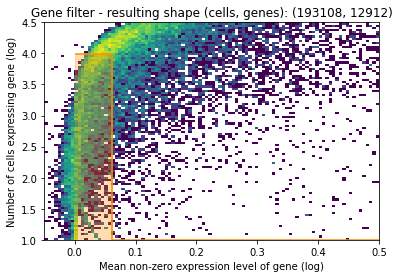

In [6]:
nonz_mean_cutoff = np.log10(1.15)
cell_count_cutoff = np.log10(10)
cell_count_cutoff2 = np.log10(adata_snrna_raw.shape[0] * 0.05)

min_genes = 100  

rcParams["axes.facecolor"] = "white"

sc.pp.filter_cells(adata_snrna_raw, min_genes=min_genes)
sc.pp.filter_genes(adata_snrna_raw, min_cells=1)

adata_snrna_raw.var['n_cells'] = np.array((adata_snrna_raw.X > 0).sum(0)).flatten()
adata_snrna_raw.var['nonz_mean'] = np.array(adata_snrna_raw.X.sum(0)).flatten() / adata_snrna_raw.var['n_cells']
    
fig, ax = plt.subplots()
ax.hist2d(np.log10(adata_snrna_raw.var['nonz_mean']),
               np.log10(adata_snrna_raw.var['n_cells']), bins=100,
               norm=mpl.colors.LogNorm(),
               range=[[-0.05,0.5], [1,4.5]]);
ax.axvspan(0,nonz_mean_cutoff, ymin=0.0, ymax=(cell_count_cutoff2-1)/3.5, color='darkorange', alpha=.3)
ax.axvspan(nonz_mean_cutoff,np.max(np.log10(adata_snrna_raw.var['nonz_mean'])), 
               ymin=0.0, ymax=(cell_count_cutoff-1)/3.5, color='darkorange', alpha=.3)
plt.vlines(nonz_mean_cutoff, cell_count_cutoff, cell_count_cutoff2, color='darkorange');
plt.hlines(cell_count_cutoff, nonz_mean_cutoff, 1, color='darkorange');
plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff, color='darkorange');
plt.xlabel("Mean non-zero expression level of gene (log)");
plt.ylabel("Number of cells expressing gene (log)");
plt.title("Gene filter - resulting shape (cells, genes): " + str(adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2)) \
         | (np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff) \
         & np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff))].shape));
plt.show();

In [7]:
adata_snrna_raw = adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2)) \
         | (np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff) \
         & np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff))]

In [8]:
adata_snrna_raw.var['SYMBOL'] = adata_snrna_raw.var_names
adata_snrna_raw.var_names = adata_snrna_raw.var['gene_ids-1']
adata_snrna_raw.var_names.name = None

/tmp/ipykernel_137611/3722040674.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_snrna_raw.var['SYMBOL'] = adata_snrna_raw.var_names


In [9]:
adata_snrna_raw.raw = adata_snrna_raw

In [10]:
np.unique(adata_snrna_raw.obs['Celltypes'])

array(['AT1', 'AT2', 'B_memory', 'B_naive', 'B_plasma_IgA',
       'B_plasma_IgG', 'B_plasmablast', 'Basal', 'CD4_EM/Effector',
       'CD4_TRM', 'CD4_naive/CM', 'CD8_EM', 'CD8_EM/EMRA', 'CD8_TRM',
       'CD8_TRM/EM', 'Chondrocyte', 'Ciliated', 'DC_1', 'DC_2',
       'DC_activated', 'DC_plasmacytoid', 'Deuterosomal', 'Dividing_AT2',
       'Dividing_Basal', 'Endothelia_Lymphatic',
       'Endothelia_vascular_Cap_a', 'Endothelia_vascular_Cap_g',
       'Endothelia_vascular_arterial_pulmonary',
       'Endothelia_vascular_arterial_systemic',
       'Endothelia_vascular_venous_pulmonary',
       'Endothelia_vascular_venous_systemic', 'Erythrocyte',
       'Fibro_adventitial', 'Fibro_alveolar', 'Fibro_immune_recruiting',
       'Fibro_myofibroblast', 'Fibro_peribronchial',
       'Fibro_perichondrial', 'ILC', 'Ionocyte_n_Brush', 'MAIT',
       'Macro_AW_CX3CR1', 'Macro_CCL', 'Macro_CHIT1', 'Macro_alv',
       'Macro_alveolar_metallothioneins', 'Macro_dividing', 'Macro_int',
       'Macro_

Add counts matrix as `adata.raw` 

We need to make sure gene IDs on both spatial and reference objects are of the same type. Since it is now impossible to modify the raw slot we have to use gene names for spatial data as well.

In [11]:
adata_snrna_raw.obs['scDonor_snBatch']

AAACCTGGTGTGAATA-1-WTDAtest7887999-0       A32_cells
AAACGGGCAACCGCCA-1-WTDAtest7887999-0       A32_cells
AACCATGGTACAGCAG-1-WTDAtest7887999-0       A32_cells
AACGTTGGTGTCCTCT-1-WTDAtest7887999-0       A32_cells
AACTCCCTCCTAGTGA-1-WTDAtest7887999-0       A32_cells
                                             ...    
TTTGGTTGTAATGCGG-1-WSSS_A_LNG8757929-1    A42_nuclei
TTTGGTTGTGCCCTTT-1-WSSS_A_LNG8757929-1    A42_nuclei
TTTGGTTTCAAGAGTA-1-WSSS_A_LNG8757929-1    A42_nuclei
TTTGTTGAGCGAGTCA-1-WSSS_A_LNG8757929-1    A42_nuclei
TTTGTTGTCTTCTGGC-1-WSSS_A_LNG8757929-1    A42_nuclei
Name: scDonor_snBatch, Length: 193108, dtype: category
Categories (15, object): ['A26_cells', 'A32_cells', 'A37_cells', 'A40_cells', ..., 'Pool5', 'A26_nuclei', 'A42_nuclei', 'A48_nuclei']

In [12]:
adata_snrna_raw.obs

,Celltypes,Celltypes_master_high,Celltypes_master_higher,Celltypes_master_higher_immune,Celltypes_master_2,Celltypes_master_3,Loc_true,Material,scsn,Donor,...,Version,Study,PoolDon,DonorPool,scDonor_snBatch,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACCTGGTGTGAATA-1-WTDAtest7887999-0,AT1,AT1,Epithelia,AT1,Epithelia,Epithelia,d_LowLeftPar,cells,cells,A32,...,10x3prime_v2,dissociation,nan,nan,A32_cells,1943,1943,5356.075684,186.790329,3.487448
AAACGGGCAACCGCCA-1-WTDAtest7887999-0,B_plasma_IgA,B_plasma,Immune,B_cell,Immune,Immune,d_LowLeftPar,cells,cells,A32,...,10x3prime_v2,dissociation,nan,nan,A32_cells,226,226,768.994751,5.476773,0.712199
AACCATGGTACAGCAG-1-WTDAtest7887999-0,Monocyte_CD16,Myeloid,Immune,Monocyte,Immune,Immune,d_LowLeftPar,cells,cells,A32,...,10x3prime_v2,dissociation,nan,nan,A32_cells,847,847,1901.789185,108.158295,5.687187
AACGTTGGTGTCCTCT-1-WTDAtest7887999-0,CD8_EM/EMRA,T_NK,Immune,CD8,Immune,Immune,d_LowLeftPar,cells,cells,A32,...,10x3prime_v2,dissociation,nan,nan,A32_cells,767,767,1783.324097,85.630554,4.801738
AACTCCCTCCTAGTGA-1-WTDAtest7887999-0,Macro_int,Myeloid,Immune,Macrophage_other,Immune,Immune,d_LowLeftPar,cells,cells,A32,...,10x3prime_v2,dissociation,nan,nan,A32_cells,799,799,1314.895386,97.600655,7.422694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTGTAATGCGG-1-WSSS_A_LNG8757929-1,T_reg,T_NK,Immune,CD4,Immune,Immune,b_Bronchi.2.3,nuclei,nuclei,A42,...,nan,nan,A42,A42none,A42_nuclei,1556,1556,2975.571777,0.000000,0.000000
TTTGGTTGTGCCCTTT-1-WSSS_A_LNG8757929-1,SMG_Mucous,Submucosal_Glands,Epithelia,Submucosal_Glands,Epithelia,Epithelia,b_Bronchi.2.3,nuclei,nuclei,A42,...,nan,nan,A42,A42none,A42_nuclei,2723,2723,7334.214355,0.000000,0.000000
TTTGGTTTCAAGAGTA-1-WSSS_A_LNG8757929-1,Basal,Epi_Basal,Epithelia,Epi_Basal,Epithelia,Epithelia,b_Bronchi.2.3,nuclei,nuclei,A42,...,nan,nan,A42,A42none,A42_nuclei,500,500,626.389465,0.000000,0.000000
TTTGTTGAGCGAGTCA-1-WSSS_A_LNG8757929-1,SMG_Mucous,Submucosal_Glands,Epithelia,Submucosal_Glands,Epithelia,Epithelia,b_Bronchi.2.3,nuclei,nuclei,A42,...,nan,nan,A42,A42none,A42_nuclei,2576,2576,6651.600586,0.000000,0.000000


## 2. Show UMAP of cells and locations

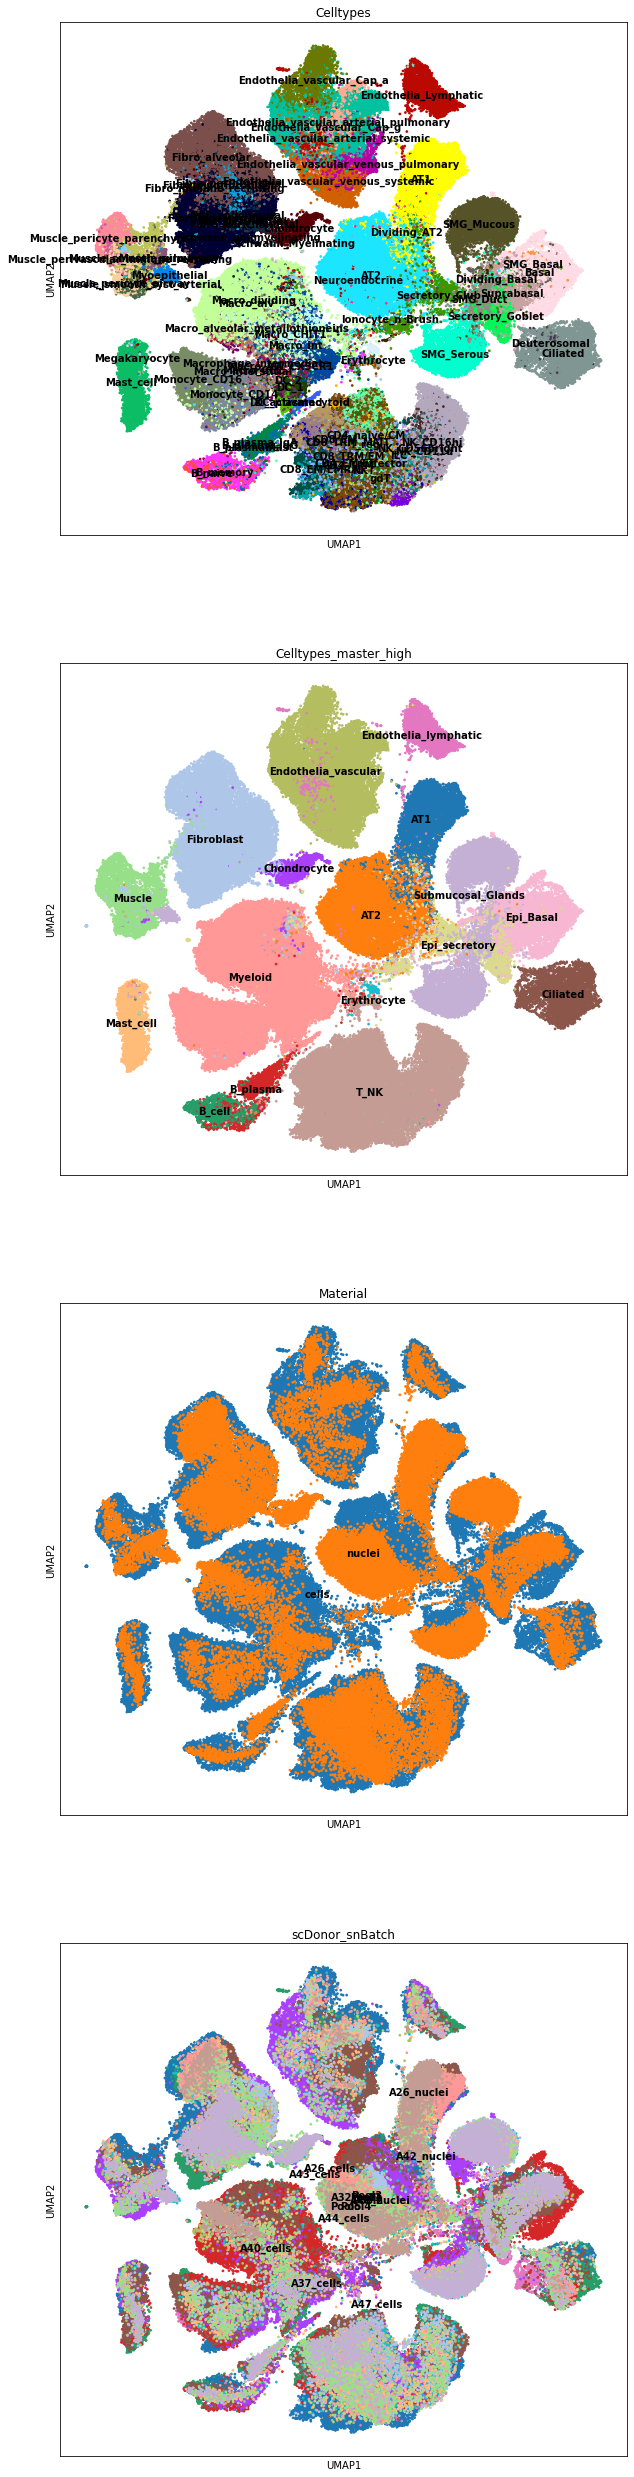

In [13]:
rcParams['figure.figsize'] = 10, 10
rcParams["axes.facecolor"] = "white"
sc.pl.umap(adata_snrna_raw, color=['Celltypes', 'Celltypes_master_high', 
                                   'Material', 'scDonor_snBatch'],
           color_map = 'RdPu', ncols = 1, legend_loc='on data',
           size=30,
           legend_fontsize=10)

Now we look at the UMAP of Visium spots

In [14]:
print(adata_snrna_raw.X.data)
adata_snrna_raw.X.data = np.round(adata_snrna_raw.X.data)
adata_snrna_raw.X.data

[1.97858    1.97858    0.98393506 ... 0.9769759  0.9701275  0.97543436]


array([2., 2., 1., ..., 1., 1., 1.], dtype=float32)

In [15]:
# prepare anndata for model
import cell2location
cell2location.models.RegressionModel.setup_anndata(
    adata=adata_snrna_raw, batch_key='Sample', labels_key='Celltypes',
    categorical_covariate_keys=['scDonor_snBatch']
)

In [16]:
# create and train the model
import pyro
mod = cell2location.models.RegressionModel(
    adata_snrna_raw,
    #amortised=True, encoder_mode="single",
    #encoder_kwargs={'dropout_rate': 0.1}
) 
mod.view_anndata_setup()

mod.train(max_epochs=4000, 
          batch_size=2476, 
          train_size=1,
          # plan_kwargs={'optim': pyro.optim.ClippedAdam(optim_args={'lr': 0.002, 'clip_norm': 10})},
          plan_kwargs={'optim': pyro.optim.Adam(optim_args={'lr': 0.002})},
          # scale_elbo=1 / (adata_snrna_raw.n_obs * adata_snrna_raw.n_vars),
          use_gpu=True)

# plot ELBO loss history during training, removing first 20 epochs from the plot
mod.plot_history(150)

# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_snrna_raw = mod.export_posterior(
    adata_snrna_raw, sample_kwargs={'num_samples': 1000, 'batch_size': 2476, 'use_gpu': True}
)

# Save model
mod.save(f"{scvi_ref_run_name}", overwrite=True)
# can be loaded later like this:
# mod = cell2location.models.RegressionModel.load(f"{scvi_run_name}_ref", adata_vis)

# Save anndata object with results
adata_file = f"{scvi_ref_run_name}/sc.h5ad"
adata_snrna_raw.write(adata_file)
adata_file

Anndata setup with scvi-tools version 0.16.0.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'Sample',
│   'labels_key': 'Celltypes',
│   'categorical_covariate_keys': ['scDonor_snBatch'],
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_cells          │ 193108 │
│          n_vars          │ 12912  │
│         n_batch          │   75   │
│         n_labels         │   80   │
│ n_extra_categorical_covs │   1    │
│ n_extra_continuous_covs  │   0    │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│         labels         │         adata.obs['_scvi_labels']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         ind_x          │           adata.obs['_indices']            │
└────────────────────────┴────────────────────────────────────────────┘

                      batch State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃    Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Sample'] │  5841STDY7991475  │          0          │
│                     │  5841STDY7991476  │          1          │
│                     │  5841STDY7991477  │          2          │
│                     │  5841STDY7991478  │          3          │
│                     │  5841STDY7991479  │          4          │
│                     │  5841STDY7991482  │          5          │
│                     │  5841STDY7991483  │          6          │
│                     │  5841STDY7991484  │          7          │
│                     │  5841STDY7991485  │          8          │
│                     │  5841STDY7991486  │          9          │
│                     │  5841STDY7991487  │         10          │
│                     │ HCATisStab7732261 │         11          │
│                     │ HCATisStab7732262 │         12          │
│                     │ HCATisStab7732263 │         13          │
│                     │ HCATisStab7732264 │         14          │
│                     │ HCA_A_LNG9387709  │         15          │
│                     │ HCA_A_LNG9387710  │         16          │
│                     │ HCA_A_LNG9387711  │         17          │
│                     │ HCA_A_LNG9387712  │         18          │
│                     │ HCA_A_LNG9387713  │         19          │
│                     │ HCA_A_LNG9387714  │         20          │
│                     │ HCA_A_LNG9387715  │         21          │
│                     │ HCA_A_LNG9387716  │         22          │
│                     │ HCA_A_LNG9387717  │         23          │
│                     │ HCA_A_LNG9387718  │         24          │
│                     │    WSSS8015042    │         25          │
│                     │    WSSS8015043    │         26          │
│                     │    WSSS8015044    │         27          │
│                     │    WSSS8015045    │         28          │
│                     │    WSSS8015046    │         29          │
│                     │    WSSS8015047    │         30          │
│                     │    WSSS8015048    │         31          │
│                     │    WSSS8015049    │         32          │
│                     │    WSSS8015050    │         33          │
│                     │    WSSS8015051    │         34          │
│                     │    WSSS8062679    │         35          │
│                     │    WSSS8062680    │         36          │
│                     │    WSSS8062681    │         37          │
│                     │    WSSS8062682    │         38          │
│                     │    WSSS8123922    │         39          │
│                     │    WSSS8123923    │         40          │
│                     │    WSSS8123924    │         41          │
│                     │    WSSS8123925    │         42          │
│                     │    WSSS8123926    │         43          │
│                     │    WSSS8123927    │         44          │
│                     │    WSSS8123928    │         45          │
│                     │    WSSS8123929    │         46          │
│                     │    WSSS8123930    │         47          │
│                     │    WSSS8123931    │         48          │
│                     │ WSSS_A_LNG8620059 │         49          │
│                     │ WSSS_A_LNG8620060 │         50          │
│                     │ WSSS_A_LNG8620061 │         51          │
│                     │ WSSS_A_LNG8620062 │         52          │
│                     │ WSSS_A_LNG8620063 │         53          │
│                     │ WSSS_A_LNG8620064 │         54          │
│                     │ WSSS_A_LNG8620065 │         55          │
│                     │ WSSS_A_LNG862006

                                  labels State Registry                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃               Categories               ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Celltypes'] │                  AT1                   │          0          │
│                        │                  AT2                   │          1          │
│                        │                B_memory                │          2          │
│                        │                B_naive                 │          3          │
│                        │              B_plasma_IgA              │          4          │
│                        │              B_plasma_IgG              │          5          │
│                        │             B_plasmablast              │          6          │
│                        │                 Basal                  │          7          │
│                        │            CD4_EM/Effector             │          8          │
│                        │                CD4_TRM                 │          9          │
│                        │              CD4_naive/CM              │         10          │
│                        │                 CD8_EM                 │         11          │
│                        │              CD8_EM/EMRA               │         12          │
│                        │               CD8_TRM/EM               │         13          │
│                        │                CD8_TRM                 │         14          │
│                        │              Chondrocyte               │         15          │
│                        │                Ciliated                │         16          │
│                        │                  DC_1                  │         17          │
│                        │                  DC_2                  │         18          │
│                        │              DC_activated              │         19          │
│                        │            DC_plasmacytoid             │         20          │
│                        │              Deuterosomal              │         21          │
│                        │              Dividing_AT2              │         22          │
│                        │             Dividing_Basal             │         23          │
│                        │          Endothelia_Lymphatic          │         24          │
│                        │       Endothelia_vascular_Cap_a        │         25          │
│                        │       Endothelia_vascular_Cap_g        │         26          │
│                        │ Endothelia_vascular_arterial_pulmonary │         27          │
│                        │ Endothelia_vascular_arterial_systemic  │         28          │
│                        │  Endothelia_vascular_venous_pulmonary  │         29          │
│                        │  Endothelia_vascular_venous_systemic   │         30          │
│                        │              Erythrocyte               │         31          │
│                        │           Fibro_adventitial            │         32          │
│                        │             Fibro_alveolar             │         33          │
│                        │        Fibro_immune_recruiting         │         34          │
│                        │          Fibro_myofibroblast           │         35          │
│                        │          Fibro_peribronchial           │         36          │
│                        │          Fibro_perichondrial           │         37          │
│                        │                  ILC                   │         38          │
│                        │            Ionocyte_n_Brush            │         39          │
│                        │              

               extra_categorical_covs State Registry               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃       Source Location        ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['scDonor_snBatch'] │ A26_cells  │          0          │
│                              │ A32_cells  │          1          │
│                              │ A37_cells  │          2          │
│                              │ A40_cells  │          3          │
│                              │ A43_cells  │          4          │
│                              │ A44_cells  │          5          │
│                              │ A47_cells  │          6          │
│                              │   Pool1    │          7          │
│                              │   Pool2    │          8          │
│                              │   Pool3    │          9          │
│                              │   Pool4    │         10          │
│                              │   Pool5    │         11          │
│                              │ A26_nuclei │         12          │
│                              │ A42_nuclei │         13          │
│                              │ A48_nuclei │         14          │
│                              │            │                     │
└──────────────────────────────┴────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1602/4000:  40%|███████████████████▏                            | 1601/4000 [4:14:41<6:22:20,  9.56s/it, v_num=1, elbo_train=8.65e+8]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [20]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_snrna_raw = mod.export_posterior(
    adata_snrna_raw, sample_kwargs={'num_samples': 1000, 'batch_size': 2476, 'use_gpu': True}
)

# Save model
mod.save(f"{scvi_ref_run_name}", overwrite=True)
# can be loaded later like this:
# mod = cell2location.models.RegressionModel.load(f"{scvi_run_name}_ref", adata_vis)

Epoch 1761/4000:  44%|████████████████████▏                         | 1760/4000 [26:09:53<33:18:03, 53.52s/it, v_num=1, elbo_train=8.65e+8]


TypeError: Incompatible object (Dataset) already exists

Above error raised while writing key 'means_per_cluster_mu_fg_CD8_EM/EMRA' of <class 'h5py._hl.group.Group'> to /

In [21]:
from re import sub
adata_snrna_raw.varm['means_per_cluster_mu_fg'].columns = \
[sub('/', '_', c) for c in adata_snrna_raw.varm['means_per_cluster_mu_fg'].columns]
adata_snrna_raw.varm['stds_per_cluster_mu_fg'].columns = \
[sub('/', '_', c) for c in adata_snrna_raw.varm['stds_per_cluster_mu_fg'].columns]
adata_snrna_raw.varm['q05_per_cluster_mu_fg'].columns = \
[sub('/', '_', c) for c in adata_snrna_raw.varm['q05_per_cluster_mu_fg'].columns]
adata_snrna_raw.varm['q95_per_cluster_mu_fg'].columns = \
[sub('/', '_', c) for c in adata_snrna_raw.varm['q95_per_cluster_mu_fg'].columns]
adata_snrna_raw.uns['mod']['factor_names'] = \
[sub('/', '_', c) for c in adata_snrna_raw.uns['mod']['factor_names']]


# Save anndata object with results
adata_file = f"{scvi_ref_run_name}/sc.h5ad"
adata_snrna_raw.write(adata_file)
adata_file

'/nfs/team205/vk7/sanger_projects/collaborations/adult_lung_mapping/results//non_amortised/v0_Adam_4000iter_snsc_selection_CCLplasma_v4Ref/sc.h5ad'

Examine QC plots

1. Reconstruction accuracy to assess if there are any issues with inference.

2. The estimated expression signatures are distinct from mean expression in each cluster because of batch effects. For scRNA-seq datasets which do not suffer from batch effect (this dataset does), cluster average expression can be used instead of estimating signatures with a model. When this plot is very different from a diagonal plot (e.g. very low values on Y-axis, density everywhere) it indicates problems with signature estimation.

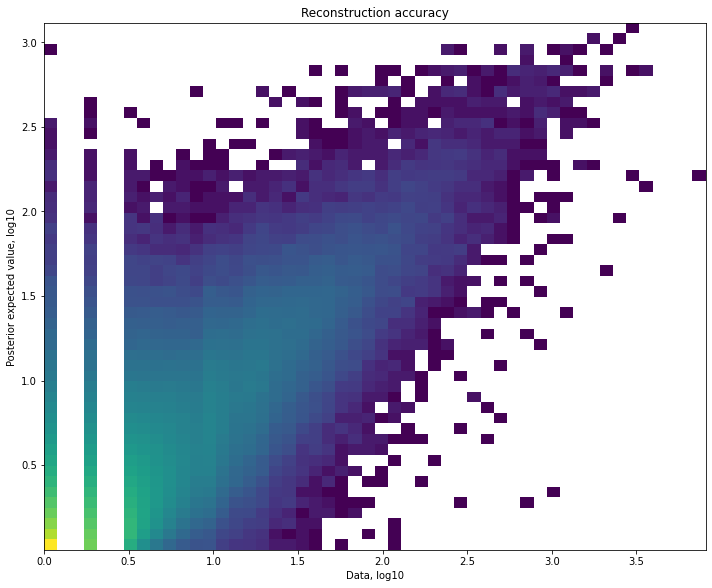

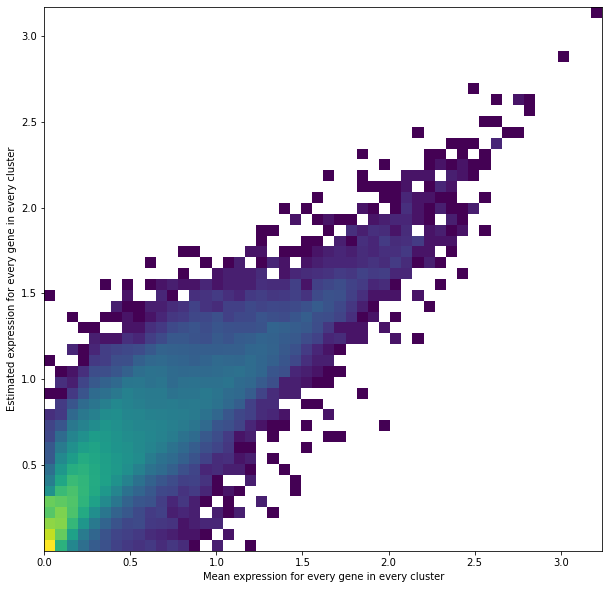

In [22]:
mod.plot_QC()

In [23]:
#mod = scvi.external.cell2location.RegressionModel.load(f"{scvi_run_name}_snsc_selection_ref", adata_snrna_raw)
adata_file = f"{scvi_ref_run_name}/sc.h5ad"
adata_snrna_raw = sc.read_h5ad(adata_file)

In [24]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_snrna_raw.varm.keys():
    inf_aver = adata_snrna_raw.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_snrna_raw.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_snrna_raw.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_snrna_raw.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_snrna_raw.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,AT1,AT2,B_memory,B_naive,B_plasma_IgA
ENSG00000187634,0.002743,0.001169,0.001174,0.002768,0.017251
ENSG00000188976,0.237687,0.269781,0.146242,0.164769,0.247318
ENSG00000188290,0.545790,0.055602,0.005998,0.008836,0.012504
ENSG00000187608,0.107529,0.002709,0.046892,0.023974,0.085622
ENSG00000188157,1.810810,0.494282,0.001927,0.003310,0.010818


In [25]:
inf_aver.sum()

AT1                  9559.322266
AT2                 12489.195312
B_memory             3429.369141
B_naive              2694.543701
B_plasma_IgA         6877.171875
                        ...     
Secretory_Club       9140.424805
Secretory_Goblet    17360.035156
Suprabasal          15238.429688
T_reg                2955.646729
gdT                  2885.379150
Length: 80, dtype: float32

Here we show how to perform the first step in one function run - train cell2location model to learn cell locations. Results are shown below and saved to:  

In [26]:
results_folder

'/nfs/team205/vk7/sanger_projects/collaborations/adult_lung_mapping/results/'

Modules and their versions used for this analysis

In [27]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

re 2.2.1
ipykernel._version 6.13.0
json 2.0.9
jupyter_client._version 7.2.2
traitlets._version 5.1.1
traitlets 5.1.1
logging 0.5.1.2
platform 1.0.8
_ctypes 1.1.0
ctypes 1.1.0
zmq.backend.cython.constants 40304
zmq.backend.cython 40304
zmq.sugar.constants 40304
zmq.sugar.version 22.3.0
zmq.sugar 22.3.0
zmq 22.3.0
argparse 1.1
zlib 1.0
_curses b'2.2'
dateutil 2.8.2
six 1.15.0
_decimal 1.70
decimal 1.70
jupyter_core.version 4.10.0
jupyter_core 4.10.0
entrypoints 0.4
jupyter_client 7.2.2
ipykernel 6.13.0
IPython.core.release 8.2.0
executing.version 0.8.3
executing 0.8.3
pure_eval.version 0.2.2
pure_eval 0.2.2
stack_data.version 0.2.0
stack_data 0.2.0
pygments 2.11.2
ptyprocess 0.7.0
pexpect 4.8.0
pickleshare 0.7.5
backcall 0.2.0
decorator 5.1.1
wcwidth 0.2.5
prompt_toolkit 3.0.29
parso 0.8.3
jedi 0.18.1
urllib.request 3.9
IPython 8.2.0
psutil 5.9.0
debugpy 1.6.0
xmlrpc.client 3.9
socketserver 0.4
http.server 0.6
pkg_resources._vendor.appdirs 1.4.3
pkg_resources.extern.appdirs 1.4.3
pkg_res